# Policy Gradient Optimization

In [1]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt

## Functions

In [2]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards # Compute exponentially decaying rewards
    disc_return /= disc_return.max() # Normalize the rewards to be within the [0,1] interval to improve numerical stability
    return disc_return

def loss_fn(preds, r): # The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
    return -1 * torch.sum(r * torch.log(preds)) # It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.


## Testing if everything is working

In [3]:
# Environment definition
env = gym.make("CartPole-v0")


# Model definition
l1 = 4 # Input data is length 4
l2 = 150
l3 = 2 # Output is a 2-length vector for the Left and the Right actions

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) # Output is a softmax probability distribution over actions
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Testing if our model returns what we want
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) # Call policy network model to produce predicted action probabilities
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) # Sample an action from the probability distribution produced by the policy network
state2, reward, done, info = env.step(action) # Take the action, receive new state and reward. The info variable is produced by the environment but is irrelevant

## Training

In [4]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99
score = [] # List to keep track of the episode length over training time
expectation = 0.0

# Starting training
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] # List of state, action, rewards (but we ignore the reward)
    
    for t in range(MAX_DUR): # While in episode
        act_prob = model(torch.from_numpy(curr_state).float()) # Get the action probabilities
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()) # Select an action stochastically
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) # Take the action in the environment
        transitions.append((prev_state, action, t+1)) # Store this transition
        if done: # If game is lost, break out of the loop
            break

    ep_len = len(transitions) # Store the episode length
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) # Collect all the rewards in the episode in a single tensor
    disc_returns = discount_rewards(reward_batch) # Compute the discounted version of the rewards
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) # Collect the states in the episode in a single tensor
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) # Collect the actions in the episode in a single tensor
    pred_batch = model(state_batch) # Re-compute the action probabilities for all the states in the episode
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() # Subset the action-probabilities associated with the actions that were actually taken 
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Training results

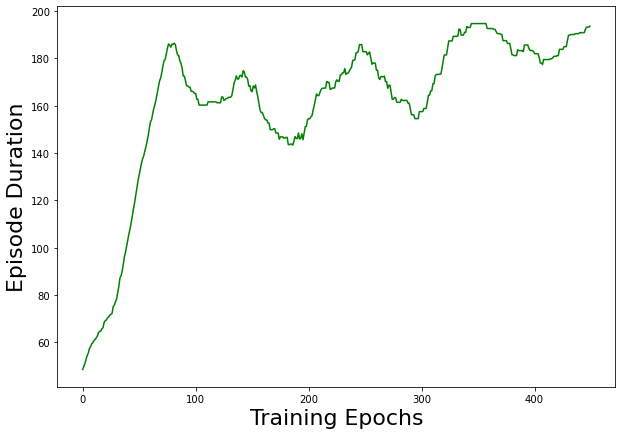

In [5]:
score = np.array(score)
avg_score = running_mean(score, 50)


plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

## Testing model

In [11]:
score = 0
expectation = 0.0

# Starting test
curr_state = env.reset()
done = False
transitions = [] # List of state, action, rewards (but we ignore the reward)

for t in range(MAX_DUR): # While in episode
    act_prob = model(torch.from_numpy(curr_state).float()) # Get the action probabilities
    action = np.argmax(act_prob.data.numpy())
    prev_state = curr_state
    curr_state, reward, done, info = env.step(action) # Take the action in the environment
    transitions.append((prev_state, action, t+1)) # Store this transition
    score += reward
    if done: # If game is lost, break out of the loop
        break

In [12]:
score = np.array(score)
print(score)

200.0
